In [40]:
import numpy as np
import cv2
# Draw bouding boxes
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [41]:
# Load SVM and Scaler
import pickle
file = open("svc.p",'rb')
car_svc = pickle.load(file)
file.close()
file2 = open("scaler.p",'rb')
car_scaler = pickle.load(file2)
file2.close()

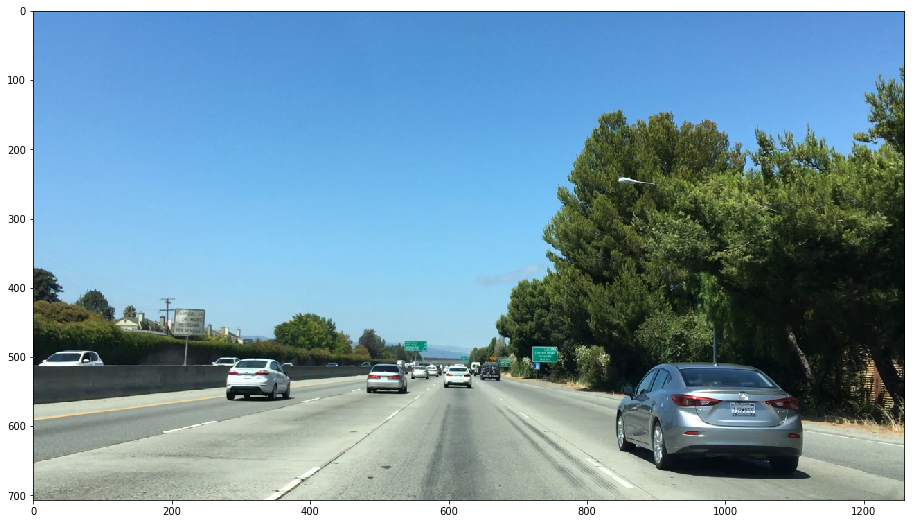

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

image = cv2.imread('bbox-example-image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
draw_image = np.copy(image)

#Hyperparameters
X_START_STOP = [(32, 1280), (0, 1280), (0, 1280), (0, 1280)]
Y_START_STOP = [(400, 520), (400, 560), (400, 640), (400, 660)]
XY_WINDOW_SIZE = [(96,96),(128,128), (192,192), (284,240)]
XY_OVERLAP = [(0.75, 0.75), (0.5, 0.75),(0.5, 0.75), (0.5, 0.9)]

# More hyperparamters from training
#Parameters for training
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
ax1.imshow(image)

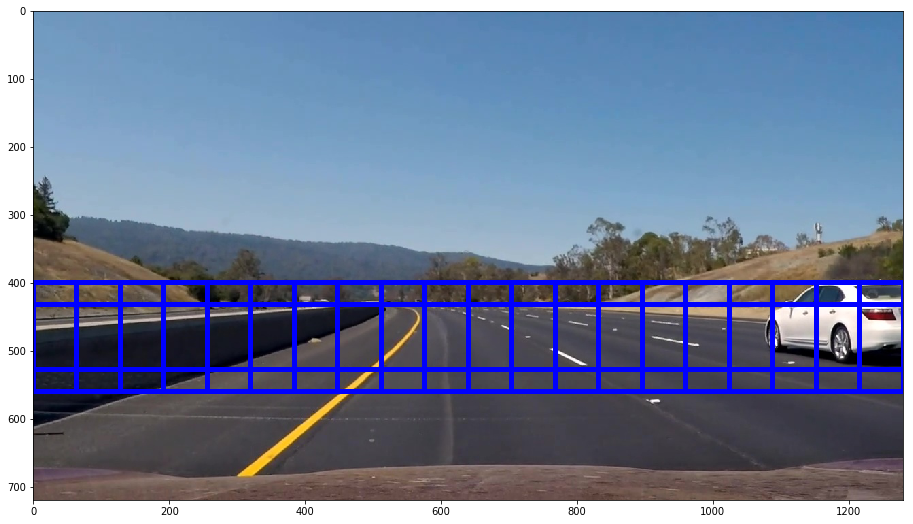

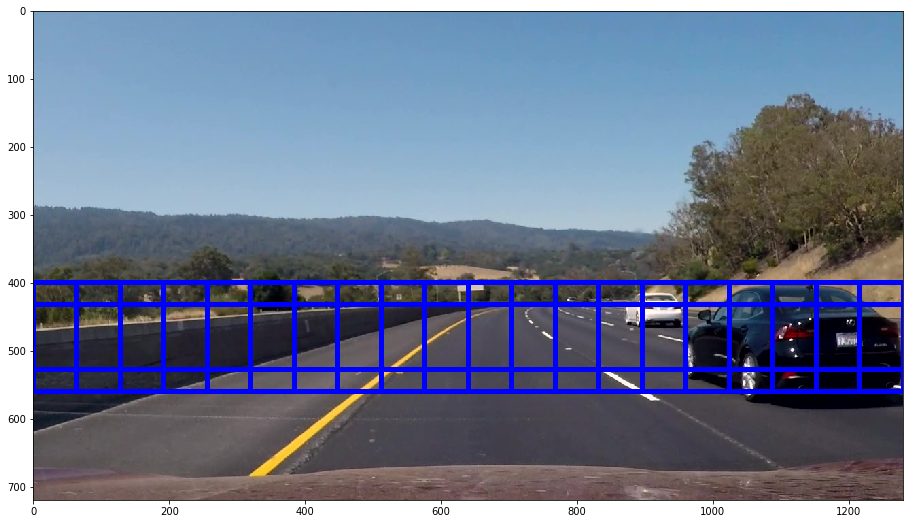

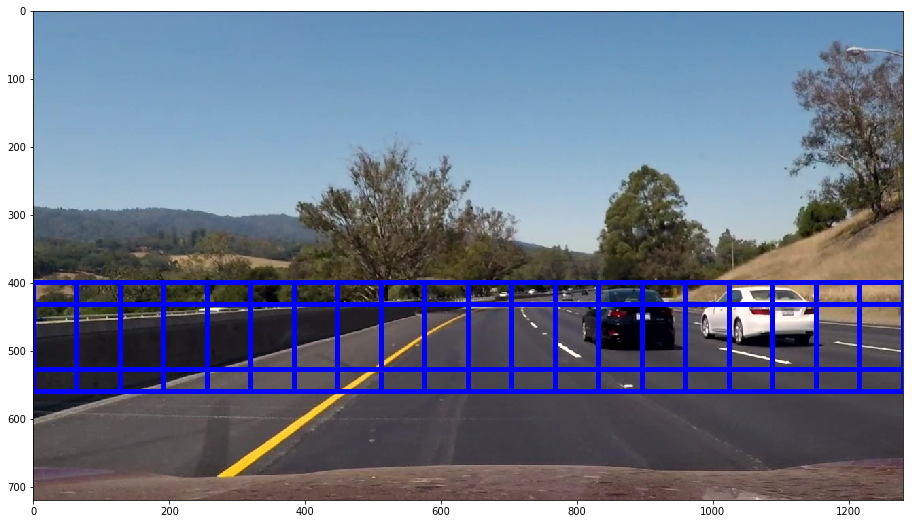

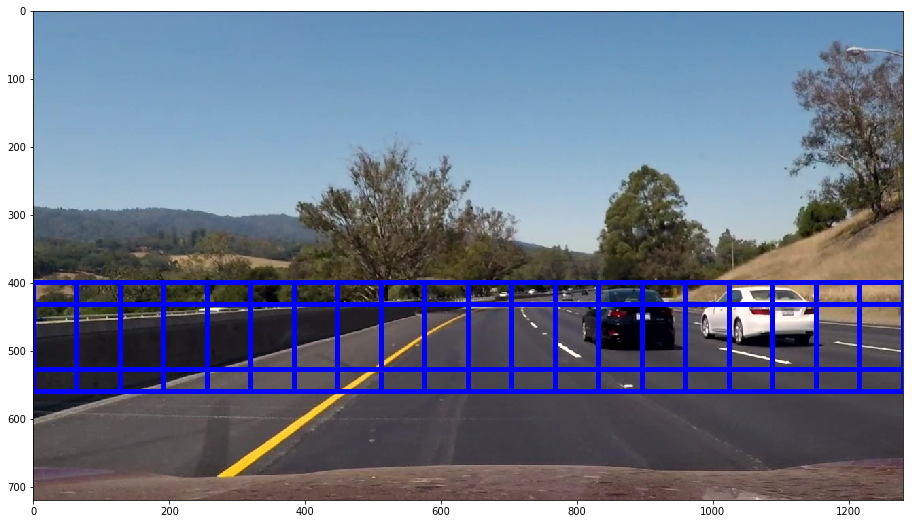

In [43]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
import glob
window_list = []

for region in range(1,2):
    windows = slide_window(image, x_start_stop=X_START_STOP[region], y_start_stop=Y_START_STOP[region], 
                    xy_window=XY_WINDOW_SIZE[region], xy_overlap=XY_OVERLAP[region])
    window_list.extend(windows)

# Draw for all test images
images = glob.glob('vlc*.jpg')
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    window_boxes = draw_boxes(img, window_list, color=(0, 0, 255), thick=6)
    f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
    ax1.imshow(window_boxes)
                    

f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
ax1.imshow(window_boxes)

In [44]:
# Optimization for single hog calculation
# images = glob.glob('*.jpg')
# for image in images:
#     img = cv2.imread(image)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     feature_array, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
#                     cells_per_block=(cell_per_block, cell_per_block), 
#                     visualize=True, feature_vector=False,  block_norm="L2-Hys")

#     print ('feature_Array: ', feature_array.shape)
#     #print ('y_blocks: ')
#     f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
#     ax1.imshow(hog_image)
    


In [45]:
# Get functions worked on for feature extraction during course work - Lesson 34
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file) # Scale of 0-255
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #print('Spatial:', len(spatial_features))
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #print('Hist:', len(hist_features))
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            #print('Hog:', len(hog_features))
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        #return features
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [46]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

C:\Users\Amrita.DESKTOP-MJJ9189\Anaconda3\envs\adv_lane\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


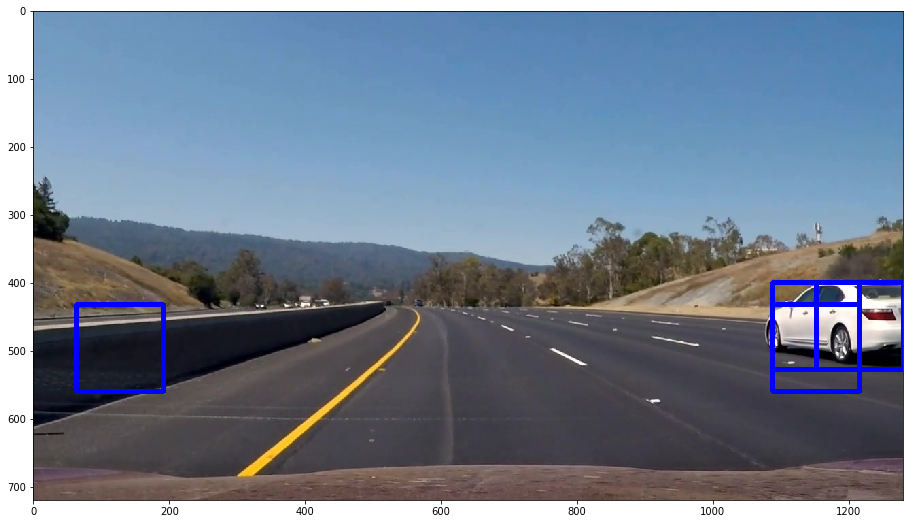

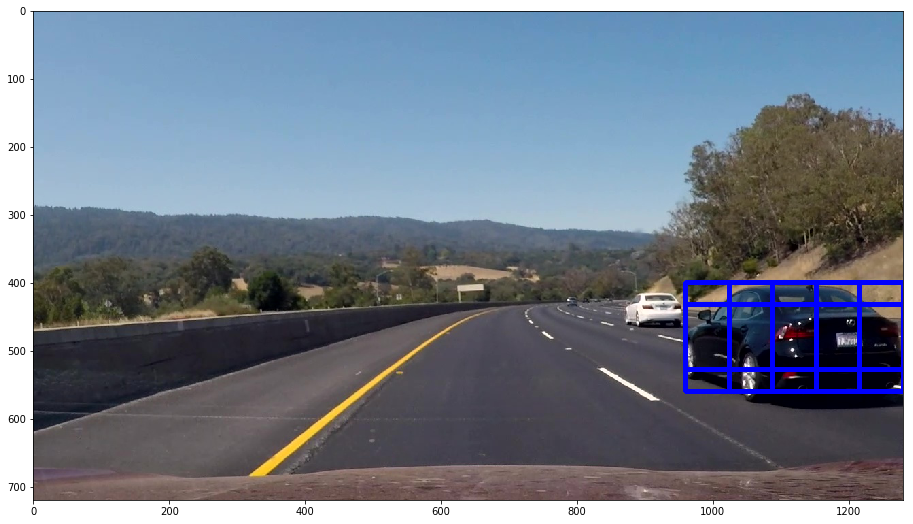

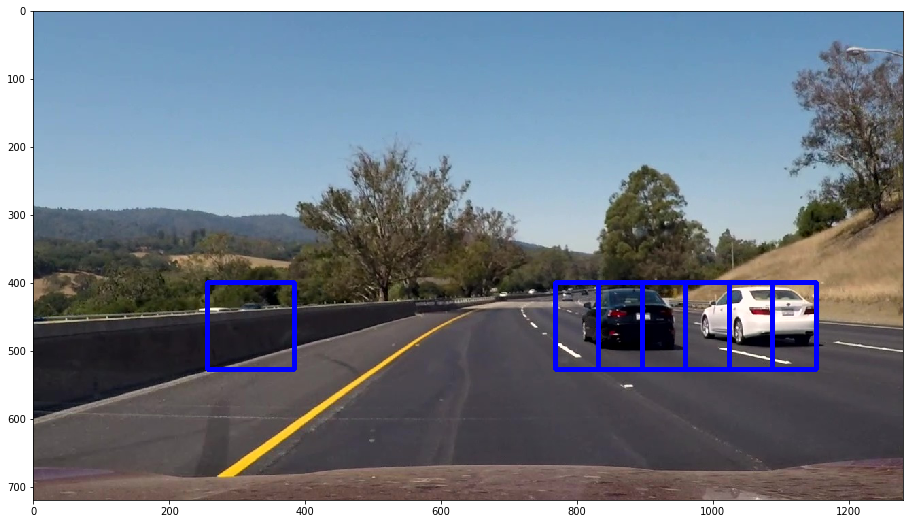

In [47]:

    
def get_hot_windows(image):
    hot_windows = search_windows(image, window_list, car_svc, car_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    return hot_windows

# Draw for all test images
images = glob.glob('vlc*.jpg')
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    window_img = draw_boxes(img, get_hot_windows(img), color=(0, 0, 255), thick=6)                    

    f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
    ax1.imshow(window_img)

In [77]:
# Tracking pipeline
import collections
class Object_Tracking():
    def __init__(self):
        self.centroids = [] #represents the centroid of each car detected
        self.bbox_queue = [] #corresponding list of bboxes for each centroid
        self.MIN_FRAMES = 5
        self.MAX_FRAMES = 10
        self.CENTROID_PIXELS = 20
    
    # Print contents
    def print(self):
        print('Centroids:')
        for i in range(len(self.centroids)):
            print(self.centroids[i])
            print('\tBbox:')
            for bbox in self.bbox_queue[i]:
                print(bbox)

    # Find an existing centroid given an updated centroid within CENTROID_PIXELS
    def find_matching_centroid(self, new_centroid):
        count = 0
        for centroid in self.centroids:
            dist = np.linalg.norm(np.array(centroid)-np.array(new_centroid))
            print('Distance:', dist)
            if  dist < self.CENTROID_PIXELS:
                return centroid, count
            count +=1
        return None, -1
    
    # Update new detections from frame
    def update_detections(self, centroid_list, bbox_list):
        count = 0
        # Update index
        update_idx =  [False for i in range(len(self.centroids))]
        
        # Update existing ones and create new ones
        for new_centroid in centroid_list:
            existing_centroid, centroid_idx = self.find_matching_centroid(new_centroid)
            if existing_centroid is not None:
                print('Updating existing one..')
                update_idx[centroid_idx] = True
                self.bbox_queue[centroid_idx].append(bbox_list[count])
            else:
                # New point found, add to centroid and bbox queue
                print('New point found, adding to list')
                self.centroids.append(new_centroid)
                #create and add bbox queue
                bbox_q = collections.deque(maxlen=self.MAX_FRAMES)
                bbox_q.append(bbox_list[count])
                self.bbox_queue.append(bbox_q)
            count+=1
    
        # For all the ones not updated, add None to the queue
        for i in range(len(update_idx)):
            if not update_idx[i]:
                self.bbox_queue[i].append(None)
    
    def get_averaged_detections(self):
        
        print('Size of car list = ', len(self.centroids))
        
        # If MAX_FRAMES Nones, then mark for deletion centroid, bbox
        update_idx =  [False for i in range(len(self.centroids))]
        
        count = 0
        for bbox_q in self.bbox_queue:
            none_count = 0
            for q_item in bbox_q:
                if q_item is None:
                    none_count +=1
            if (none_count >=self.MAX_FRAMES):
                #Mark for deletion
                update_idx[count] = True
                print('Marking centroid for deletion - car not there anymore..')
            count +=1
        
        # Delete centroid
        new_centroids = []
        for i in range(len(update_idx)):
            if not update_idx[i]:
                new_centroids.append(self.centroids[i])
        self.centroids = new_centroids
        
        # Delete queue
        new_bbox_queue = []
        for i in range(len(update_idx)):
            if not update_idx[i]:
                new_bbox_queue.append(self.bbox_queue[i])
        self.bbox_queue = new_bbox_queue
            
        
        
        # Check if there are size- none frames > 5, then compute average bbox, update centroid and return
        bbox_list = []
        
        for i in range(len(self.bbox_queue)):
            count = 0
            centroid = [0,0]
            width = 0
            height = 0
            for bbox in self.bbox_queue[i]: # Got the bbox
                if bbox is not None:
                    count +=1
                    height += bbox[1][0]-bbox[0][0]
                    width  += bbox[1][1]-bbox[0][1]
                    centroid[0] += (bbox[0][0]+ bbox[1][0])//2
                    centroid[1] += (bbox[0][1]+ bbox[1][1])//2
            if(count >0):
                centroid[0] = centroid[0]//count
                centroid[1] = centroid[1]//count
                # Update centroid location
                self.centroids[i] = centroid
            if(count >= 5):
                width = width//count
                height = height//count
                bbox_temp = [(centroid[0] - height//2,centroid[1] - width//2),(centroid[0] + height//2,centroid[1] + width//2)]
                bbox_list.append(bbox_temp)
            
                    
                    
        return bbox_list

# Tests
# obj_track = Object_Tracking()
# obj_track.update_detections([(500,500)], [[(400,400), (600,600)]])
# obj_track.update_detections([(500,500)], [[(400,400), (600,600)]])
# obj_track.update_detections([(500,500)], [[(400,400), (600,600)]])
# obj_track.update_detections([(510,500)], [[(400,400), (610,600)]])
# print(obj_track.get_averaged_detections())
# obj_track.update_detections([(520,500)], [[(400,400), (620,600)]])
# obj_track.print()
# print(obj_track.get_averaged_detections())
# #obj_track.update_detections([(510,510)], [[(380,380), (620,620)]])
# # Test removal 
# for i in range(10):
#     obj_track.update_detections([], [[]])
# obj_track.print()
# print(obj_track.get_averaged_detections())
# obj_track.print()

New point found, adding to list
Distance: 0.0
Updating existing one..
Distance: 0.0
Updating existing one..
Distance: 10.0
Updating existing one..
Size of car list =  1
[]
Distance: 19.0
Updating existing one..
Centroids:
[501, 500]
	Bbox:
[(400, 400), (600, 600)]
[(400, 400), (600, 600)]
[(400, 400), (600, 600)]
[(400, 400), (610, 600)]
[(400, 400), (620, 600)]
Size of car list =  1
[[(400, 400), (606, 600)]]
Centroids:
[503, 500]
	Bbox:
None
None
None
None
None
None
None
None
None
None
Size of car list =  1
Marking centroid for deletion - car not there anymore..
[]
Centroids:


C:\Users\Amrita.DESKTOP-MJJ9189\Anaconda3\envs\adv_lane\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Num cars detected:  1
Num cars detected:  1
Num cars detected:  2


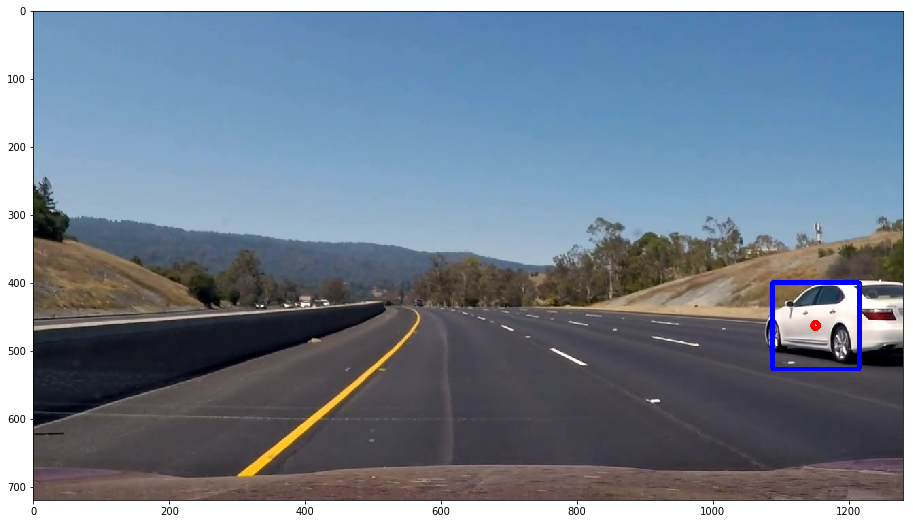

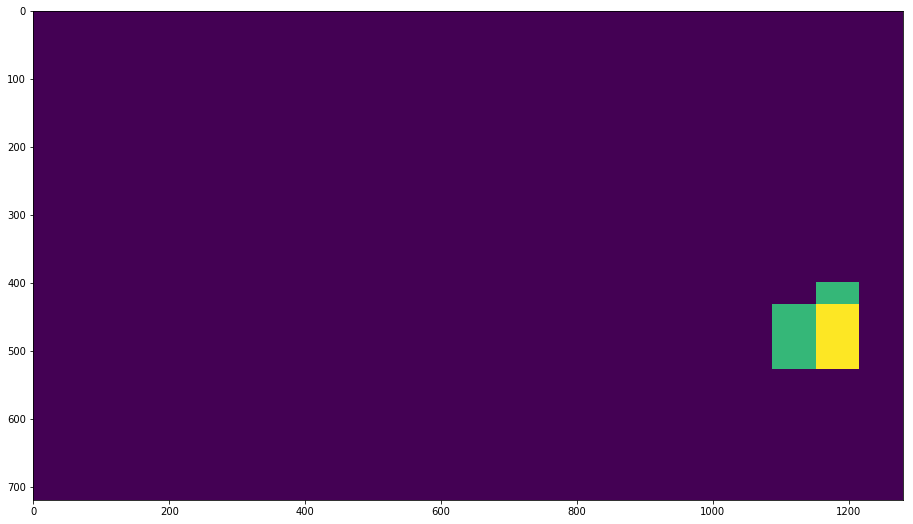

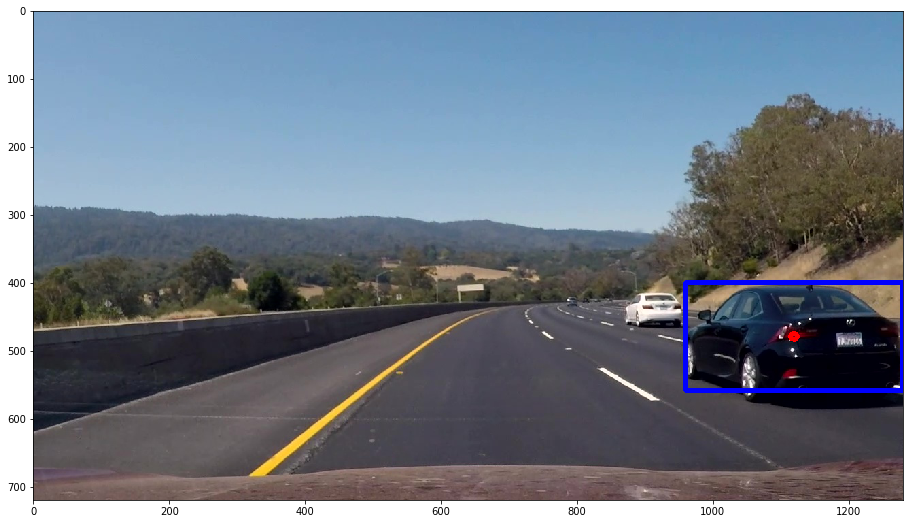

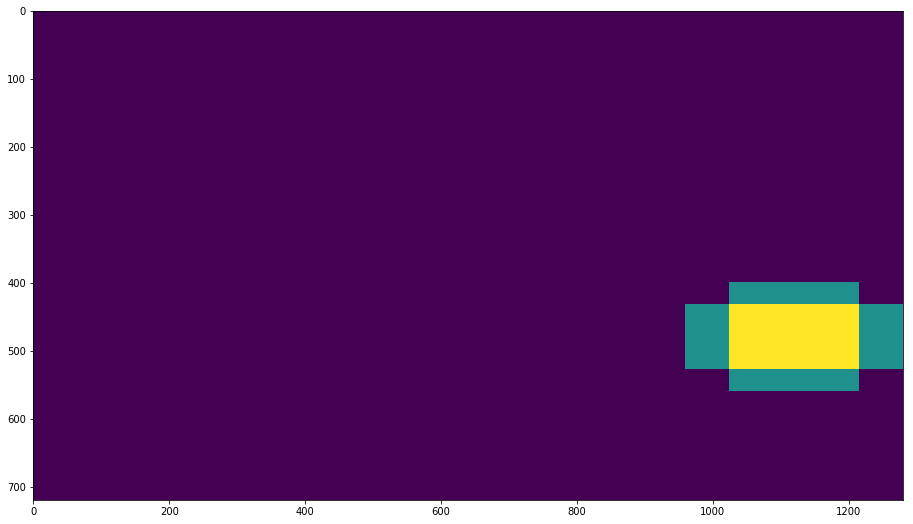

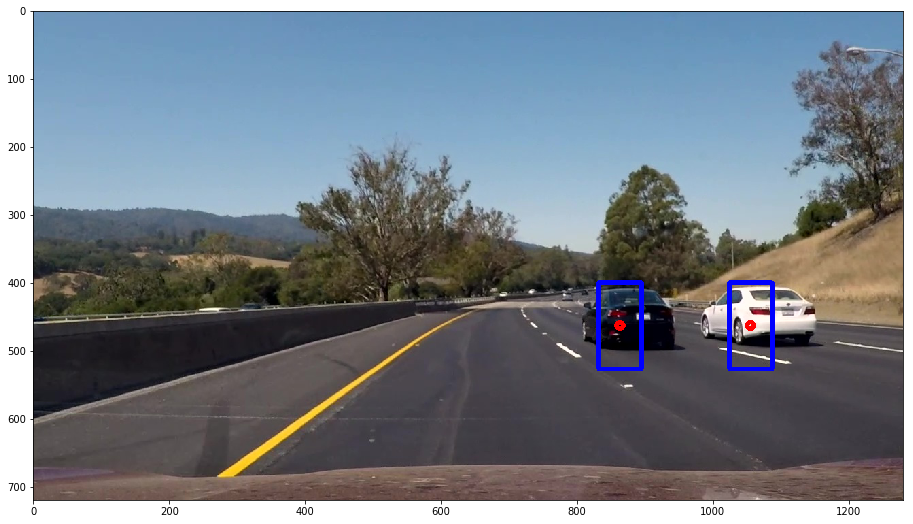

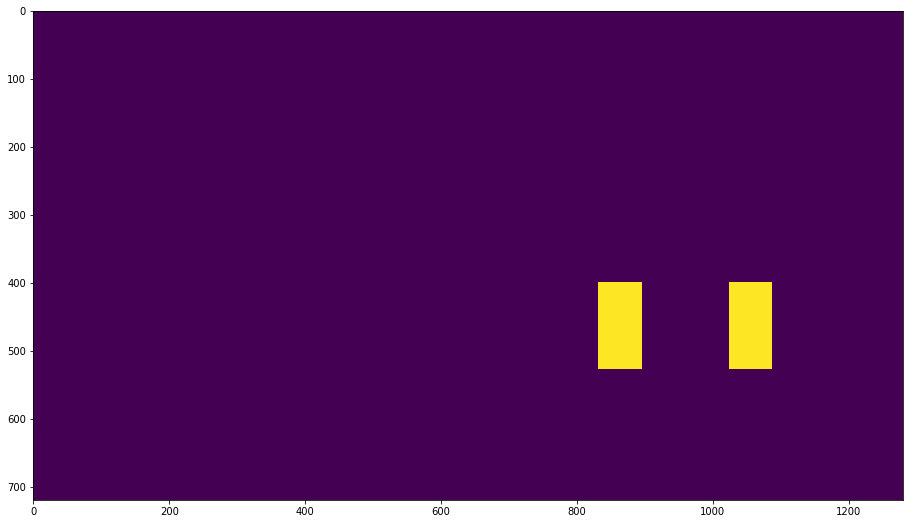

In [49]:
# Heat Maps - Lesson 37
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    
    centroid_list = []
    bb_list = []
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        centroid = ((bbox[0][0] + bbox[1][0])//2, (bbox[0][1] + bbox[1][1])//2)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        cv2.circle(img, centroid, 5, (255,0,0), 6)
        centroid_list.append(centroid)
        bb_list.append(bbox)
    # Return the image
    return img, centroid_list, bb_list


def get_clean_bboxes(image, hot_windows, heatMap = False):
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    print ('Num cars detected: ', labels[1])
    draw_img, centroid_list, bb_list = draw_labeled_bboxes(np.copy(image), labels)
    
    if heatMap:
        return draw_img, heatmap
    else:
        return draw_img

def process_image(image, heatMap = False):
    return get_clean_bboxes(image, get_hot_windows(image), heatMap)


for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    draw_img, heatmap = process_image(img, True)

    
    f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
    ax1.imshow(draw_img)

    f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
    ax1.imshow(heatmap)


In [44]:
from moviepy.editor import VideoFileClip

lanes_output = 'output1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(32,40)
lanes_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
lanes_clip.write_videofile(lanes_output, audio=False)

clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4


100%|███████████████████████████████████████████████████████████████████████████████▌| 200/201 [03:45<00:01,  1.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1.mp4 

